# Planejamento da Solução

## Input

1. Problema de negócio
 - Selecionar os clientes mais valiosos para criar um programa de fidelidade
2. Conjunto de dados
 - Vendas de e-commerce no período de um ano

## Output

1. <b>Indicação das pessoas que farão parte do programa de fidelidade
    - Tabela com: <br>
            |customer_id | is_insider| 
            |    1      |     yes   | 
            |    2      |     no    | 
 
2. <b>Responder as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV
        - Baixa recência (compra mais frequentemente)
        - Alto basket size (tamanho de cesta)
        - Baixa probabilidade de churn (periodo que passa e não vai mais comprar)
        - Alta previsão de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Alta média das avaliações
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente (podem ser utilizadas para busca clientes semelhantes)
        - Idade
        - Localização
    - Escrever caacterísticas do consumo
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort (como um grupo de pessoas se comporta ao longo do tempo)
        - Sabendo que pessoas que compram calça na primeira compram geram maior faturamento futuro, posso otimizar campanhas
        - Pessoas da localidade X trazem maior faturamento 
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar com uma pessoa do grupo
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser não parecida com uma pessoa do grupo (começa a se distanciar do cluster)


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa


# 0.0. IMPORTS

In [56]:
import pandas as pd
import seaborn as sns

import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML

from inflection import underscore
import pickle

In [2]:
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m
import umap.umap_ as ump

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Helper Functions

In [45]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=50
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

## 0.2. Loading Data

In [4]:
data_raw = pd.read_csv('../datasets/Ecommerce.csv',encoding='latin-1')
data_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0. PASSO 01 - DATA DESCRIPTION

In [5]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [6]:
df1.columns = df1.columns.to_series().apply(underscore)

## 1.2. Data Dimensions

In [7]:
print(f'Counting {df1.shape[0]} rows and {df1.shape[1]} columns')

Counting 541909 rows and 8 columns


## 1.3. Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fillout NA's

In [10]:
# first cicle --> remove NA's
print(f'Removing {df1.shape[0] - df1.dropna().shape[0]} rows')
df1 = df1.dropna()

print(f'Remain: {df1.shape[0]} rows')

Removing 135080 rows
Remain: 406829 rows


## 1.6. Verifying Types

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64')

df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [13]:
df_num_attibutes = num_attributes.describe()

df_num_attibutes.loc['kurtosis',] = num_attributes.describe().kurtosis().values
df_num_attibutes.loc['skew'] = num_attributes.describe().skew().values

df_num_attibutes = df_num_attibutes.T

df_num_attibutes['range'] = df_num_attibutes['max'] - df_num_attibutes['min']

df_num_attibutes = df_num_attibutes[['min', 'max', 'range', 'mean' , '50%', 'std', 
                  'skew', 'kurtosis']].reset_index().rename(columns={'index': 'attribute', '50%': 'median'})

df_num_attibutes

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,2.370745,6.140757
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315162,2.779201,7.776348
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.600303,2.820824,7.968443


#### 1.7.1. Numerical Attributes - Looking for errors

1. Quantity negativo --> Pode ser devolução

2. unit_price igual a 0 --> promoção? 

In [14]:
# quantity < 0 --> aparenta ser devolução/descontos/etc --> separar entre compras e retornos
print(f"{df1[df1['quantity'] <0].count().values[0]} rows with quantity < 0")

# unit_price == 0 --> nao vi razão aparente, então vou considerar com erro e deleta-las
print(f"{df1[df1['unit_price'] ==0].count().values[0]} rows with unit_price = 0 --> will be deleted")

8905 rows with quantity < 0
40 rows with unit_price = 0 --> will be deleted


### 1.7.1. Categorical Attributes

In [15]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### invoice no

In [47]:
# invoice no
letter_index_invoice = cat_attributes['invoice_no'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'])} rows invoice_no with letters --> same rows that quantity < 0")
print('So, a letter in invoice number means quantity < 0, probabably return/discount/etc\n')
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'].unique())} unique invoice_no with letters")

8905 rows invoice_no with letters --> same rows that quantity < 0
So, a letter in invoice number means quantity < 0, probabably return/discount/etc

3654 unique invoice_no with letters


#### stock code

In [17]:
# stock code
only_letters_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('^[A-Z a-z]+$',x) != None else False)
print(list(cat_attributes.loc[only_letters_stock,'stock_code'].unique()))

# Ação --> Por enquanto retirar ['POST' 'D' 'M' 'BANK CHARGES' 'PADS' 'DOT' 'CRUK'] --> não vou considerar compras

['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']


In [18]:
at_least_oneletter_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].unique())} unique stock_code with letters\n")
print(f"{cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].sample(5).values} ...")

886 unique stock_code with letters

['47591D' '85099B' '85230B' '85049C' '85123A'] ...


#### description

In [19]:
# Ação --> Deletar description

#### country

In [20]:
# Ação --> Deletar European Community e Unspecified
# Todo --> Tentar alterar os nomes 
cat_attributes['country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

# 2.0. PASSO 02 - FILTRAGEM DE VARIÁVEIS

In [21]:
df2 = df1.copy()

In [22]:
### Categorical Attibutes ###
# stock code != ['POST', 'D', 'M', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'])]

# description
df2 = df2.drop(columns=['description'])

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

In [23]:
### Numerical Attibutes ###

# unit_price
# df2.loc[df2['unit_price'] > 0.01, :].sort_values('unit_price', ascending=True)
df2 = df2.loc[df2['unit_price'] > 0.01, :]

# quantity
df_purchases = df2.loc[df2['quantity'] > 0]
df_returns = df2.loc[df2['quantity'] < 0]

# 3.0. PASSO 03 - FEATURE ENGINEERING

In [24]:
df3 = df2.copy()

## 3.1. Mapa Mental de Hipoteses

## 3.2. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

### 2.1.2. Hipoteses Produto

### 2.1.3. Hipoteses Tempo

## 3.3. Lista final de hipoteses
--> Selecionando as hipoteses que posso validar com os dados nesse momento

## 3.4. Feature Engineering

In [51]:
# creating a reference dataframe --> only id's
df_reference = df3[['customer_id']].drop_duplicates(ignore_index=True)

# Revenue --> Faturamento --> Quantity * Price
df_purchases.loc[:, 'revenue'] = (df_purchases['quantity'] * df_purchases['unit_price'])
revenue_per_client = df_purchases[['customer_id', 'revenue']].groupby('customer_id').sum()
df_reference = df_reference.merge(revenue_per_client, on='customer_id', how='left')

# Recency --> Today - Last day purchase
last_buy_date_per_client = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_reference = df_reference.merge(last_buy_date_per_client, on='customer_id', how='left').rename(columns={'invoice_date': 'recency'})
df_reference['recency'] = (df_purchases['invoice_date'].max() - df_reference['recency']).dt.days


# Frequency
helper_group = df_purchases[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).count().reset_index()
frequency_per_client = helper_group[['customer_id', 'quantity']].groupby('customer_id').count().reset_index()
df_reference = df_reference.merge(frequency_per_client, on='customer_id', how='left').rename(columns={'quantity': 'frequency'})


# Returns
helper_group = df_returns[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).count().reset_index()
return_per_client = helper_group[['customer_id', 'quantity']].groupby('customer_id').count().reset_index()
df_reference = df_reference.merge(return_per_client, on='customer_id', how='left').rename(columns={'quantity': 'returns'})
df_reference['returns'] = df_reference['returns'].fillna(0) # empty means no returns

# Avg ticket
df_reference['avg_ticket'] = df_reference['revenue'] / df_reference['frequency']


df_reference.head()

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,customer_id,revenue,recency,frequency,returns,avg_ticket
0,17850,5391.21,372.0,34.0,1.0,158.565000
1,13047,3232.59,56.0,9.0,7.0,359.176667
2,12583,6705.38,2.0,15.0,2.0,447.025333
3,13748,948.25,95.0,5.0,0.0,189.650000
4,15100,876.00,333.0,3.0,3.0,292.000000


In [52]:
# Dropar os outros NA's --> Suas purchases foram eliminadas por algum processo anterior --> 28
df_reference = df_reference.dropna(axis=0).reset_index(drop=True)

# changing types
df_reference[['recency', 'frequency', 'returns']] = df_reference[['recency', 'frequency', 'returns']].astype('int64')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [57]:
df4 = df_reference.copy()
pickle.dump(df4, open('../datasets/intermediary_data_df4.pkl', 'wb'))

## 4.1. Analise Univariada

### 4.1.1. Response Variable

### 4.1.2. Numerical Variable

### 4.1.3. Categorical Variable

## 4.2. Analise Bivariada

### 4.2.1. Resumo das Hipoteses

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

### 4.3.2. Categorical Attributes

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [61]:
#df4 = pd.read_pickle('../datasets/intermediary_data_df4.pkl')
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Scaling

## 5.3. Transformacao

### 5.3.1. Encoding

### 5.3.2. Response Variable Transformation

### 5.3.3. Nature Transformation

# 6.0. PASSO 06 - FEATURE SELECTION

In [29]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test

## 6.2. Feature Selection

# 7.0. PASSO 07 - FINDING THE NUMBER OF CLUSTERS

HYPERPARAMETER FINE TUNING

In [30]:
df7 = df6.copy()

In [31]:
X = df7.drop(columns=['customer_id'])

In [32]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluste Sum of Square (WSS)

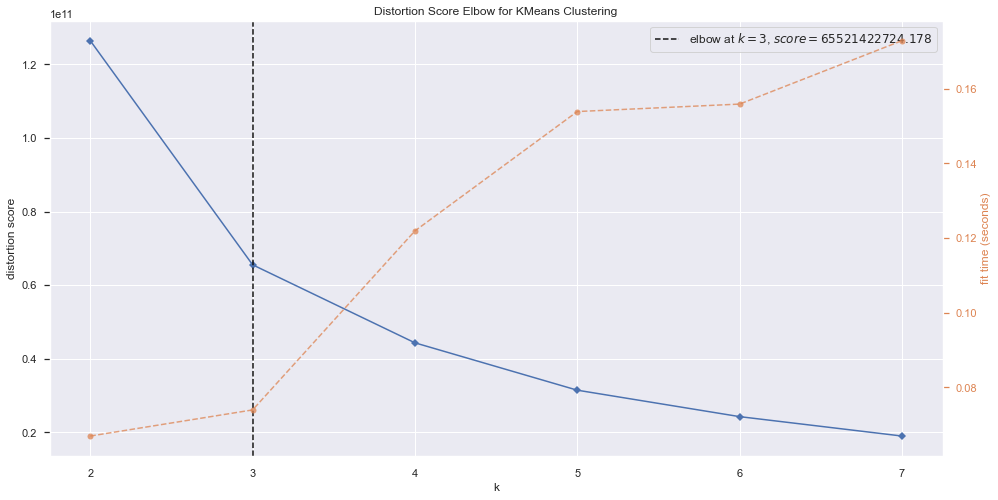

In [33]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score (SS)

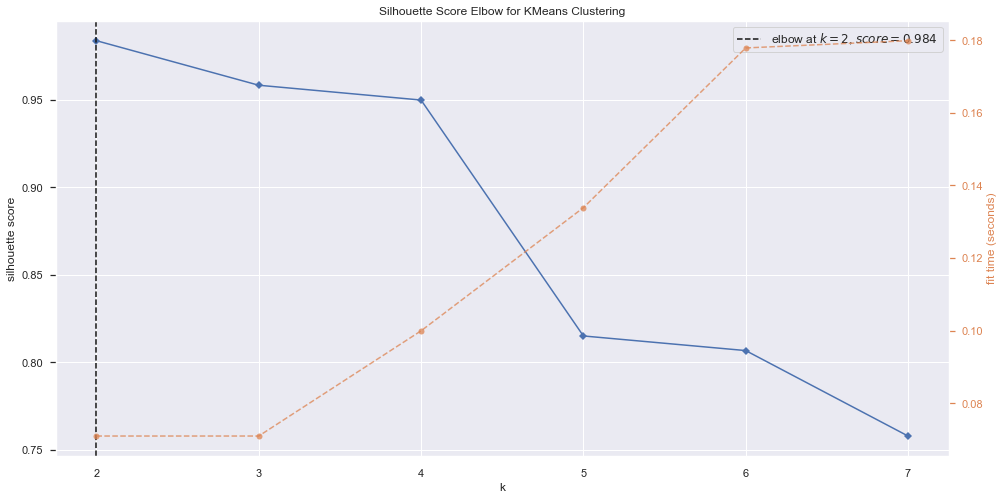

In [34]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette',timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Analysis

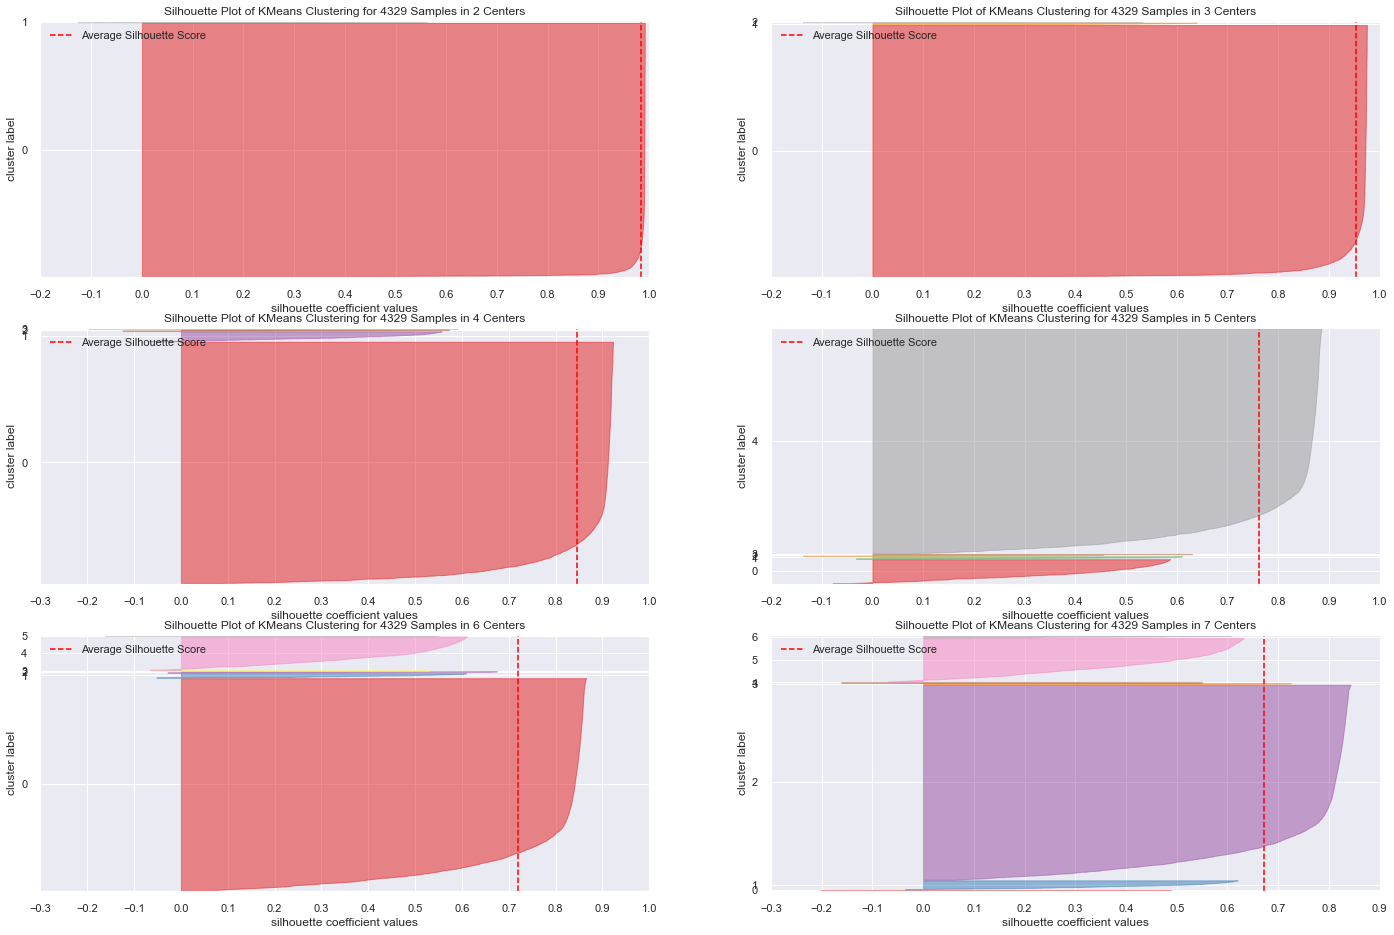

In [35]:
fig, ax = plt.subplots(3,2,figsize=(24,16))
for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)
    
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. PASSO 08 - MODEL TRAINING

## 8.1. K-Means

In [36]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [37]:
# WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

# SS
print(f'SS: {m.silhouette_score(X, labels, metric="euclidean"):.3f}')

WSS: 49270672591.93
SS: 0.846


# 9.0. PASSO 09 - CLUSTER ANALYSIS

In [38]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,revenue,recency,frequency,returns,avg_ticket,cluster
0,17850,5391.21,372,34,1,158.565000,0
1,13047,3232.59,56,9,7,359.176667,0
2,12583,6705.38,2,15,2,447.025333,1
3,13748,948.25,95,5,0,189.650000,0
4,15100,876.00,333,3,3,292.000000,0


## 9.1. Visualization Inspection

In [39]:
# fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
# fig.show()

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


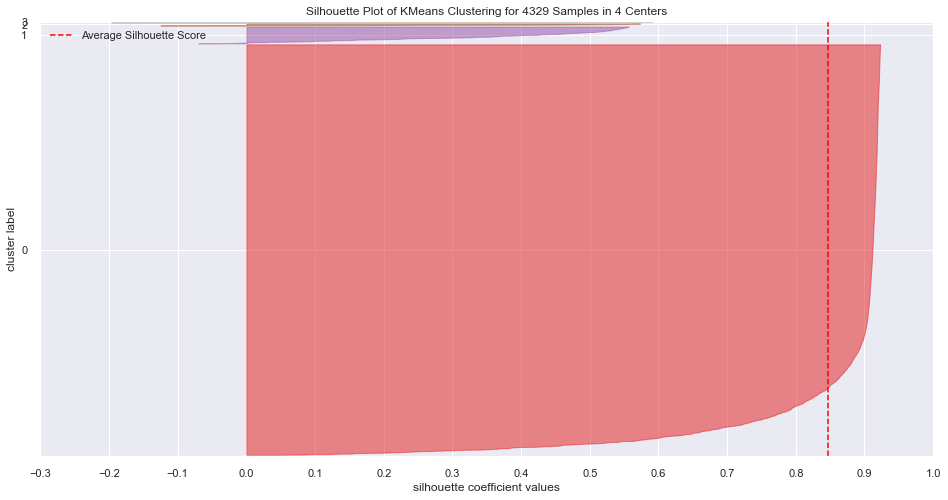

In [40]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.1.1. 2d plot

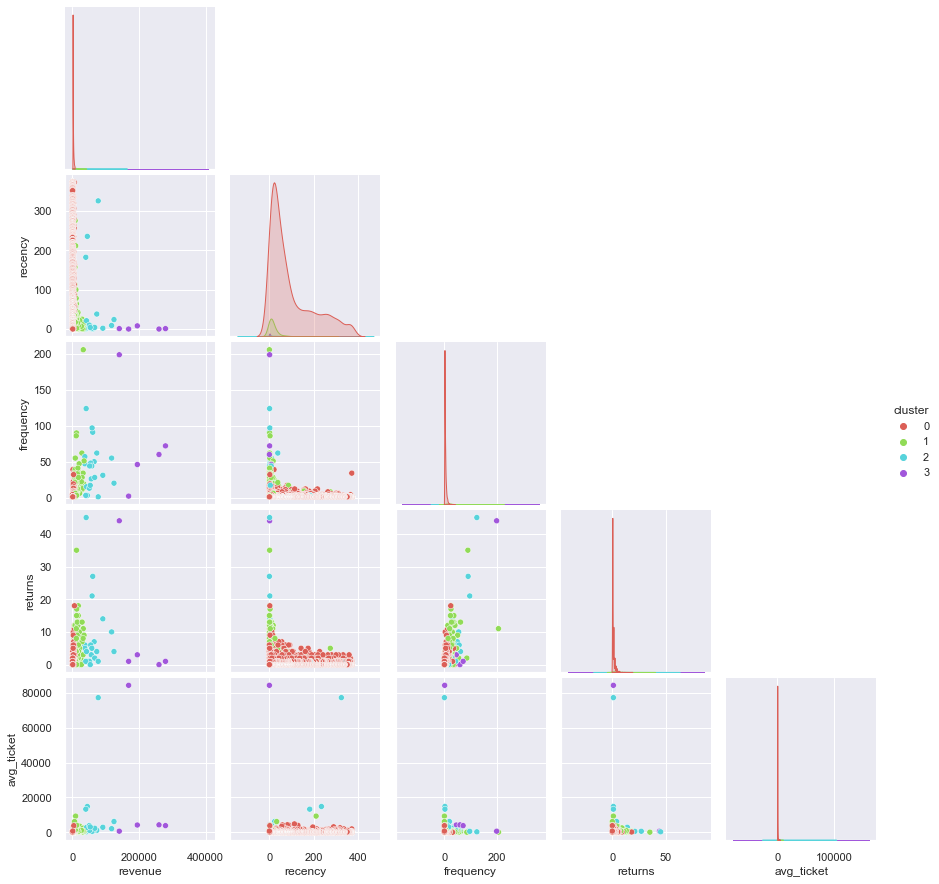

In [41]:
df_viz = df9.drop(columns=['customer_id'])
sns.pairplot(df_viz, hue='cluster', corner=True, palette=sns.color_palette("hls", len(df9['cluster'].unique())));

## 9.1.2. Machine Learning - Manifold

- Redução de dimensionalidade
1. PCA - Matrix, Espaço de Distância - Espaço de Hilbert - 9 Condições - Colorários

2. UMAP, t-SNE (2009) - Manifold - Topologia

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

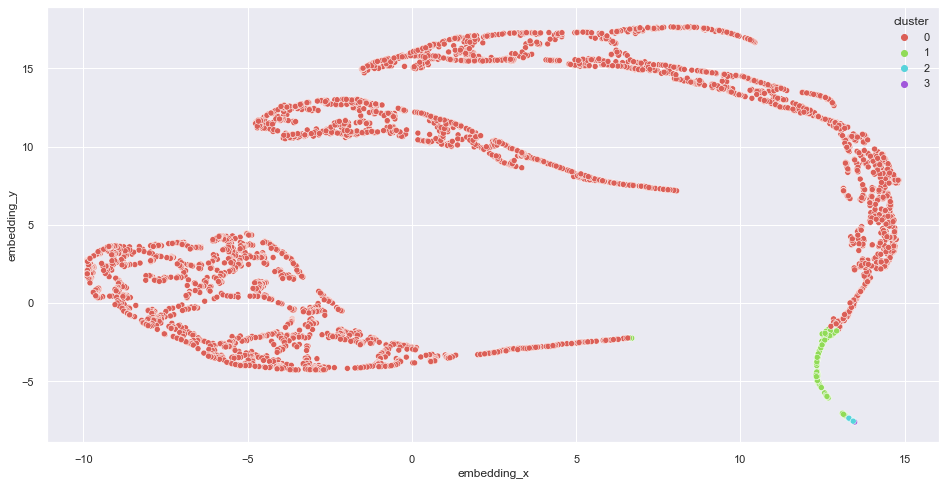

In [42]:
# projeção do X em outro espaço
reducer = ump.UMAP(random_state=99,n_neighbors=20 ) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_viz, x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())))

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

## 9.2. Cluster Profile

In [43]:
# Number of customers
df_profile = pd.DataFrame({'count': df9['cluster'].value_counts(), 
                                    'percent': df9['cluster'].value_counts(normalize=True) * 100})

df_profile.index.name = 'cluster'

df_profile = df_profile.reset_index()

# Average in other metrics
average_metrics_by_cluster = df9.drop(columns=['customer_id']).groupby('cluster').mean().reset_index()


df_profile = df_profile.merge(average_metrics_by_cluster, on='cluster').sort_values('revenue', ascending=False)
df_profile

,cluster,count,percent,revenue,recency,frequency,returns,avg_ticket
3,3,5,0.115500,208453.866000,2.000000,75.800000,9.800000,19475.187225
2,2,21,0.485100,61914.902381,42.047619,41.714286,8.000000,6673.677031
1,1,169,3.903904,11491.580828,18.656805,19.597633,4.295858,927.262420
0,0,4134,95.495495,1083.543031,95.548863,3.344702,0.582487,341.604770


In [44]:
for _,linha in df_profile.iterrows():
    print(f"Cluster {linha['cluster']+1:.0f}")
    print(f"Número de clientes: {linha['count']:.0f} ({linha['percent']:.2f}% da base)")
    print(f"Recência em média: {linha['recency']:.2f} dias")
    print(f"Frequência média: {linha['frequency']:.2f} compras")
    print(f"Receita em média: U$ {linha['revenue']:,.2f}")
    print(f"AVG Ticket: U$ {linha['avg_ticket']:,.2f}/compra")
    print('\n')

Cluster 4
Número de clientes: 5 (0.12% da base)
Recência em média: 2.00 dias
Frequência média: 75.80 compras
Receita em média: U$ 208,453.87
AVG Ticket: U$ 19,475.19/compra


Cluster 3
Número de clientes: 21 (0.49% da base)
Recência em média: 42.05 dias
Frequência média: 41.71 compras
Receita em média: U$ 61,914.90
AVG Ticket: U$ 6,673.68/compra


Cluster 2
Número de clientes: 169 (3.90% da base)
Recência em média: 18.66 dias
Frequência média: 19.60 compras
Receita em média: U$ 11,491.58
AVG Ticket: U$ 927.26/compra


Cluster 1
Número de clientes: 4134 (95.50% da base)
Recência em média: 95.55 dias
Frequência média: 3.34 compras
Receita em média: U$ 1,083.54
AVG Ticket: U$ 341.60/compra




# 10.0. PASSO 10 - DEPLOY TO PRODUCTION